In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import robust_laplacian
from scipy.sparse.linalg import eigsh
import gpytoolbox as gpy
from scipy.spatial import ConvexHull
from scipy.interpolate import RBFInterpolator
import open3d as o3d
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors

2025-07-07 10:43:20.000860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751894000.017243 1285052 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751894000.022446 1285052 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751894000.035307 1285052 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751894000.035326 1285052 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751894000.035327 1285052 computation_placer.cc:177] computation placer alr

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
tf.random.set_seed(314159)
np.random.seed(314159)

In [3]:
tmax = 1.0

In [4]:
# Compute the area density function of the surface - p is a point (u,v)
def areaDensity(p, surface):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(p)
    u = p[:,0]
    v = p[:,1]
    s = surface(u, v)

  J = tape.batch_jacobian(s, p)

  s_u = J[:,:,0]
  s_v = J[:,:,1]

  cross_product = tf.linalg.cross(s_u, s_v)

  area = tf.norm(cross_product, keepdims=True, axis=1)

  return area

In [5]:
def findBound(surface, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, size_grid=100):
  u = tf.linspace(umin, umax, size_grid)
  v = tf.linspace(vmin, vmax, size_grid)

  u, v = tf.meshgrid(u, v)
  pts = tf.stack([tf.reshape(u, [-1]), tf.reshape(v, [-1])], axis=1)

  areas = areaDensity(pts, surface)

  return tf.reduce_max(areas)

In [6]:
def hh_polynomials(x, y, z):
  p1 = tf.ones_like(x)

  p2 = x
  p3 = y
  p4 = z

  p5 = 2*z**2 - x**2 - y**2
  p6 = x*z
  p7 = y*z
  p8 = x**2 - y**2
  p9 = 2*x*y

  return tf.stack([p1, p2, p3, p4], axis=0)

In [7]:
l2_values = [0, 1, 1, 1]

In [8]:
init_modes = 4

In [9]:
def u0(x, y, z, coefficients, k=0.3):
  u = 0.0*x
  harmonic_basis = hh_polynomials(x, y, z)
  for i in range(harmonic_basis.shape[0]):
    u += coefficients[:,i:i+1] * harmonic_basis[i]
  return u

In [10]:
def u_analytic(x, y, z, t, coefficients, k=0.3):
  u = 0.0*x
  harmonic_basis = hh_polynomials(x, y, z)
  for i in range(harmonic_basis.shape[0]):
    li = l2_values[i]
    u += coefficients[:,i:i+1] * harmonic_basis[i] * tf.exp(-li * (li + 1) * k * t)
  return u

In [11]:
def sphere(u, v, a=1.0, b=1.0, c=1.0):
  return tf.stack([a * tf.sin(u) * tf.cos(v), b * tf.sin(u) * tf.sin(v), c * tf.cos(u)], axis=1)

In [12]:
def generateDomainPoints(n, surface, max=max, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, saftey_factor=3):
  batch_size = n * saftey_factor

  max = findBound(surface, size_grid=100, umin=umin, umax=umax, vmin=vmin, vmax=vmax)

  U = tf.random.uniform((batch_size,), minval=umin, maxval=umax)
  V = tf.random.uniform((batch_size,), minval=vmin, maxval=vmax)
  W = tf.random.uniform((batch_size,), minval=0.0, maxval=1.0)

  P = tf.stack([U, V], axis=1)
  A = areaDensity(P, surface) / (max * 1.05)

  mask = W <= tf.squeeze(A)

  accept_U = tf.boolean_mask(U, mask)
  accept_V = tf.boolean_mask(V, mask)

  if tf.shape(accept_U)[0] < n or tf.shape(accept_V)[0] < n:
    print('Not enough points generated - increase saftey_factor')
    return
  accept_U = accept_U[0:n]
  accept_V = accept_V[0:n]
  domain_pts = tf.stack([accept_U, accept_V], axis=1)
  if tf.shape(domain_pts)[0] > n:
    domain_pts = domain_pts[:,0:n]

  return domain_pts

In [13]:
def generateCollocationPoints(n, surface, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0, tmax=1.0):
  domain_pts = generateDomainPoints(n, surface)
  xyz = surface(domain_pts[:,0], domain_pts[:,1])
  t = tf.random.uniform((n,), minval=tmin, maxval=tmax)
  return tf.stack([xyz[:,0], xyz[:,1], xyz[:,2], t], axis=1)

In [14]:
def generateInitialPoints(n, surface, coefficients, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi):
  xyz = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax)[:,0:3]
  x = xyz[:,0:1]
  y = xyz[:,1:2]
  z = xyz[:,2:3]
  t = tf.zeros_like(x)
  return tf.squeeze(tf.stack([x, y, z, t, u0(x, y, z, coefficients)], axis=1))

In [15]:
N_data = 16
N_sensor = 256
N_inputs = 7500
modes = 50
width = 32
depth = 4

In [16]:
# sensor_points = tf.expand_dims(generateCollocationPoints(N_sensor, sphere, umin=0.0, umax=np.pi, vmin=0.0, vmax=2*np.pi)[:,0:3], axis=0)

In [17]:
sensor_points = tf.convert_to_tensor(np.load('256sensors_heat_sphere.npy'), dtype=tf.float32); sensor_points.shape

I0000 00:00:1751894003.395119 1285052 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 922 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:02:00.0, compute capability: 8.6


TensorShape([1, 256, 3])

In [18]:
# np.save('64sensors_heat_sphere.npy', sensor_points)

In [19]:
# sensor_points = tf.linspace(start=[0.0, 0.0], stop=[np.pi, 2*np.pi], num=N_sensor)
# sensor_points = tf.expand_dims(sphere(sensor_points[:,0], sensor_points[:,1]), axis=0)

In [20]:
def generatePoints(n, surface, sensor_points, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0, tmax=1.0):
  pde_pts = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax, tmin=tmin, tmax=tmax)

  x_sensor = sensor_points[:,:,0]
  y_sensor = sensor_points[:,:,1]
  z_sensor = sensor_points[:,:,2]

  coefficients = tf.random.normal((n, init_modes))

  u_sensor_points = u0(x_sensor, y_sensor, z_sensor, coefficients)
  ic_pts = generateInitialPoints(n, surface, coefficients, umin=umin, umax=umax, vmin=vmin, vmax=vmax)

  return pde_pts, ic_pts, u_sensor_points, coefficients

In [21]:
# pde_pts, ic_pts, u_sensor_pts, coefficients = generatePoints(N_inputs, sphere, sensor_points, umin=0.0, umax=np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0, tmax=tmax)

In [22]:
# np.save('2048pde_train_sphere.npy', pde_pts)
# np.save('2048u0_train_sphere_4mode.npy', u_sensor_pts)
# np.save('2048coefficients_train_sphere_4mode.npy', coefficients)

In [23]:
pde_pts = tf.convert_to_tensor(np.load('7500pde_train_sphere.npy'), dtype=tf.float32)
ic_pts = tf.zeros((N_inputs, 5))
u_sensor_pts = tf.convert_to_tensor(np.load('7500_256_u0_train_sphere_4mode.npy'), dtype=tf.float32)
coefficients = tf.convert_to_tensor(np.load('7500coefficients_train_sphere_4mode.npy'), dtype=tf.float32)

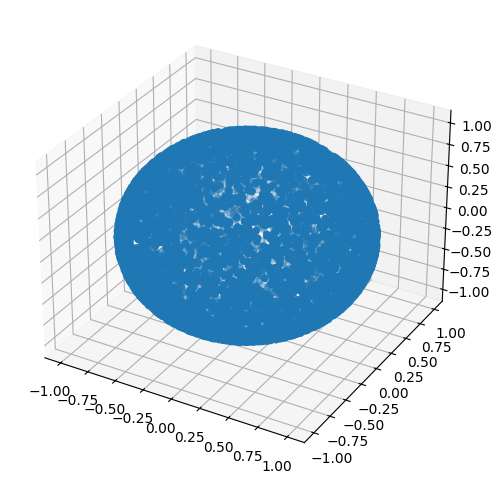

In [24]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
x, y, z = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2]
scatter = ax.scatter(x, y, z)
plt.show()

In [25]:
print(pde_pts.shape)
print(ic_pts.shape)
print(u_sensor_pts.shape)
print(coefficients.shape)

(7500, 4)
(7500, 5)
(7500, 256)
(7500, 4)


In [26]:
def normalVector(x, y, z):
  # Generate the mesh and triangulation from the point cloud data
  pts = tf.stack([x, y, z], axis=1)
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(pts)

  # We need the normal vector for the algorithm
  pcd.estimate_normals()
  pcd.orient_normals_towards_camera_location(pcd.get_center())
  pcd.normals = o3d.utility.Vector3dVector(-np.asarray(pcd.normals))
  return tf.cast(tf.stack(np.asarray(pcd.normals), axis=0), tf.float32)

In [27]:
# Generate the projection matrix at a point p
def projMatrix(x, y, z, normals):
    p = tf.stack([x, y, z], axis=1)
    n = normals
    n = tf.expand_dims(n, axis=2)
    n_outer = tf.matmul(n, tf.transpose(n, [0, 2, 1]))
    I = tf.eye(3, batch_shape=[tf.shape(p)[0]])
    return I - n_outer

In [28]:
smin = tf.reduce_min(u_sensor_pts, axis=0) 
smax = tf.reduce_max(u_sensor_pts, axis=0)

In [29]:
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    return 2.0*(inputs-self.xmin)/(self.xmax-self.xmin)-1.0

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [30]:
def buildModel(width, depth, N_sensor):
  pmin = tf.constant([-1.0, -1.0, -1.0, 0.0], dtype=tf.float32)
  pmax = tf.constant([1.0, 1.0, 1.0, tmax], dtype=tf.float32)

  trunk_x = tf.keras.layers.Input(shape=(1,))
  trunk_y = tf.keras.layers.Input(shape=(1,))
  trunk_z = tf.keras.layers.Input(shape=(1,))
  trunk_t = tf.keras.layers.Input(shape=(1,))
  b = tf.keras.layers.Concatenate()([trunk_x, trunk_y, trunk_z, trunk_t])
  b = Normalize(pmin, pmax)(b)
  for i in range(depth):
    b = tf.keras.layers.Dense(width, activation='tanh')(b)
  trunk_out = tf.keras.layers.Dense(width, activation='linear')(b)

  branch_coeffs_input = b = tf.keras.layers.Input(shape=(N_sensor,))
  b = Normalize(smin, smax)(b)
  for i in range(depth):
    b = tf.keras.layers.Dense(width, activation='tanh')(b)
  branch_out = tf.keras.layers.Dense(width, activation='linear')(b)
  #branch_out = tf.keras.layers.Reshape((1, width))(branch_out)

  out = tf.keras.layers.Multiply()([trunk_out, branch_out])
  out = tf.keras.layers.Dense(1, use_bias=False)(out)

  return tf.keras.Model([trunk_x, trunk_y, trunk_z, trunk_t, branch_coeffs_input], out)

In [31]:
def L2Error(u_true, u_pred):
  return tf.norm(u_true - u_pred) / tf.norm(u_true)

In [32]:
def hardConstraint(model, x, y, z, t, spectral_coefficients, coefficients):
    pts = tf.stack([x, y, z, t], axis=1)
    x, y, z = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1])
    nn = tf.squeeze(model([x, y, z, t, spectral_coefficients]))

    u = tf.squeeze(u0(x, y, z, coefficients)) + t * nn

    return u

In [ ]:
def normalVector(xyz, knn=30):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamKNN(knn=knn)
    )
    pcd.orient_normals_towards_camera_location(pcd.get_center())
    normals = np.asarray(pcd.normals, dtype=np.float32)
    return normals / np.linalg.norm(normals, axis=1, keepdims=True)

In [ ]:
# Got this from AI
def compute_normal_jacobian(xyz, normals, k=200, h=0.5):
    """
    xyz: (N,3)
    normals: (N,3)
    k: number of neighbors
    h: length‐scale for Gaussian weighting
    returns: (N,3,3)
    """
    N = xyz.shape[0]
    jac = np.zeros((N, 3, 3), dtype=np.float32)

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(xyz)
    distances, indices = nbrs.kneighbors(xyz)

    for i in range(N):
        neigh = indices[i, 1:]
        A = xyz[neigh] - xyz[i]         # (k,3)
        B = normals[neigh] - normals[i] # (k,3)

        # Gaussian weights, shape (k,)
        w = np.exp(- (distances[i,1:]**2) / (h*h))
        # build weighted A and B
        Wsqrt = np.sqrt(w)[:, None]     # (k,1)
        Aw = A * Wsqrt                  # each row scaled
        Bw = B * Wsqrt

        # solve Aw @ J = Bw
        J, *_ = np.linalg.lstsq(Aw, Bw, rcond=None)
        jac[i] = J

    return jac

In [35]:
normals = normalVector(pde_pts[:,0:3])
normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals), dtype=tf.float32)

In [36]:
@tf.function
def trainingStep(model, optimizer, pde_pts, ic_pts, u_sensors, coefficients, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0):
  x, y, z, t = tf.split(pde_pts, 4, axis=1)
  t = tf.squeeze(t)
  xi, yi, zi, ti, ui = tf.split(ic_pts, 5, axis=1)
  ui = tf.squeeze(ui)

  x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
  xyz = tf.stack([x, y, z], axis=1)
  pde_pts = tf.stack([x, y, z, t], axis=1)
  with tf.GradientTape() as tape:
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x, y, z, t])
      tape2.watch(xyz)
      u_pde = hardConstraint(model, x, y, z, t, u_sensors, coefficients) 
    ux, uy, uz, ut = tape2.gradient(u_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

    uxx = tape2.gradient(ux, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    uyy = tape2.gradient(uy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    uzz = tape2.gradient(uz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    uxy = tape2.gradient(ux, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    uxz = tape2.gradient(ux, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    uyz = tape2.gradient(uy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    grads = tf.stack([ux, uy, uz], axis=1)

    laplacians = uxx + uyy + uzz

    # normal = tempNormal(normal_model, xyz)# Collection of normal vectors at each point in pts

    directional_nu = tf.reduce_sum(normals * grads, axis=1) # Directional derivatives of u in direction of the normal

    row0 = tf.stack([uxx, uxy, uxz], axis=1)
    row1 = tf.stack([uxy, uyy, uyz], axis=1) 
    row2 = tf.stack([uxz, uyz, uzz], axis=1) 
    hessian = tf.stack([row0, row1, row2], axis=1)

    directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    # normal_jacobian = tape2.batch_jacobian(normal, xyz, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))

    surface_grads = grads - normals * tf.expand_dims(directional_nu, axis=-1)
    surface_laplacians = laplacians - surface_hess * directional_nu - directional_nu_second

    # laplacian_a = tf.squeeze(laplacian_approx(u_pde, L_pde, M_inv))

    eqn = 0.3 * surface_laplacians - ut

    pde_loss = tf.reduce_mean(eqn**2)

    # u_init_pred = tf.squeeze(model([ic_pts[:,0:4], u_sensors]))

    # ic_loss = tf.reduce_mean((u_init_pred - ui)**2)

    ic_loss = 0.0

    loss = lambda_pde * pde_loss + lambda_ic * ic_loss

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss, pde_loss, ic_loss

In [37]:
def train(model, optimizer, pde_pts, ic_pts, u_sensors, coefficients, normals, normal_jacobian, epochs=1000):
  losses = []
  pde_losses = []
  ic_losses = []
  maes = []
  test_coeffs = tf.random.normal((1, init_modes))

  batch_size = 256

  dataset = (
  tf.data.Dataset.from_tensor_slices((pde_pts, coefficients, u_sensor_pts, normals, normal_jacobian))
  .shuffle(N_inputs)
  .batch(batch_size)
  .prefetch(tf.data.AUTOTUNE)
            )

  for epoch in range(epochs):   
    # if epoch % 10000 == 0:
    #   pde_pts, ic_pts, u_sensor_pts, coefficients = generatePoints(N_inputs, sphere, sensor_points, umin=0.0, umax=np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0, tmax=tmax)
    #   spectral_coefficients = tf.transpose(phi_dagger @ (M @ tf.transpose(u_sensor_pts)))
    for pde_batch, coeff_batch, u_sensor_batch, normal_batch, normal_jac_batch in dataset:
      loss, pde_loss, ic_loss = trainingStep(model, optimizer, pde_batch, ic_pts, u_sensor_batch, coeff_batch, normal_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0)
      # else:
      #   loss, pde_loss, ic_loss = trainingStep(model, optimizer, pde_pts, ic_pts, u_sensors, normals, phi, phi_dagger, evals, M, lambda_ic=1e4, lambda_pde=1.0)
        
      losses.append(loss)
      pde_losses.append(pde_loss)
      ic_losses.append(ic_loss)
    if epoch % 100 == 0:
      x, y, z, t = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2], pde_pts[:,3]
      X_sens = sensor_points[:, :, 0]
      Y_sens = sensor_points[:, :, 1]
      Z_sens = sensor_points[:, :, 2]

      test_u_sensor = tf.tile(u0(X_sens, Y_sens, Z_sens, test_coeffs), multiples=[N_inputs, 1])

      u_pred = tf.squeeze(hardConstraint(model, x, y, z, t, test_u_sensor, test_coeffs))
      u_true = tf.squeeze(u_analytic(x, y, z, t, test_coeffs))
      mae = tf.reduce_mean(tf.abs(u_pred - u_true))
      maes.append(mae)
      print(f"Epoch {epoch} - PDE Loss {pde_loss: .6f} - IC Loss {ic_loss: .6f} - Total Loss {loss: .6f} - MAE {mae: .4f}")
  
  return losses, pde_losses, ic_losses, maes

In [38]:
model = buildModel(width, depth, N_sensor)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.5)

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [40]:
losses, pde_losses, ic_losses, maes = train(model, optimizer, pde_pts, ic_pts, u_sensor_pts, coefficients, normals, normal_jacobian, epochs=5000)
losses = [l.numpy() for l in losses]
pde_losses = [l.numpy() for l in pde_losses]
ic_losses = [l.numpy() for l in ic_losses]

2025-07-07 10:43:32.199240: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0 - PDE Loss  0.470329 - IC Loss  0.000000 - Total Loss  0.470329 - MAE  0.1546


2025-07-07 10:43:32.486970: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-07 10:43:32.795869: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-07 10:43:33.410810: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-07 10:43:34.650606: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-07 10:43:37.151786: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-07 10:43:42.064943: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100 - PDE Loss  0.000684 - IC Loss  0.000000 - Total Loss  0.000684 - MAE  0.0230


2025-07-07 10:43:51.887052: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 200 - PDE Loss  0.000249 - IC Loss  0.000000 - Total Loss  0.000249 - MAE  0.0204


2025-07-07 10:44:13.066506: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 300 - PDE Loss  0.000143 - IC Loss  0.000000 - Total Loss  0.000143 - MAE  0.0202
Epoch 400 - PDE Loss  0.000089 - IC Loss  0.000000 - Total Loss  0.000089 - MAE  0.0195
Epoch 500 - PDE Loss  0.000065 - IC Loss  0.000000 - Total Loss  0.000065 - MAE  0.0218


2025-07-07 10:44:54.603502: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 600 - PDE Loss  0.000054 - IC Loss  0.000000 - Total Loss  0.000054 - MAE  0.0193
Epoch 700 - PDE Loss  0.000057 - IC Loss  0.000000 - Total Loss  0.000057 - MAE  0.0185
Epoch 800 - PDE Loss  0.000062 - IC Loss  0.000000 - Total Loss  0.000062 - MAE  0.0173
Epoch 900 - PDE Loss  0.000066 - IC Loss  0.000000 - Total Loss  0.000066 - MAE  0.0183
Epoch 1000 - PDE Loss  0.000052 - IC Loss  0.000000 - Total Loss  0.000052 - MAE  0.0192


2025-07-07 10:46:18.354431: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1100 - PDE Loss  0.000041 - IC Loss  0.000000 - Total Loss  0.000041 - MAE  0.0184
Epoch 1200 - PDE Loss  0.000061 - IC Loss  0.000000 - Total Loss  0.000061 - MAE  0.0176
Epoch 1300 - PDE Loss  0.000040 - IC Loss  0.000000 - Total Loss  0.000040 - MAE  0.0179
Epoch 1400 - PDE Loss  0.000044 - IC Loss  0.000000 - Total Loss  0.000044 - MAE  0.0195
Epoch 1500 - PDE Loss  0.000039 - IC Loss  0.000000 - Total Loss  0.000039 - MAE  0.0178
Epoch 1600 - PDE Loss  0.000058 - IC Loss  0.000000 - Total Loss  0.000058 - MAE  0.0200
Epoch 1700 - PDE Loss  0.000046 - IC Loss  0.000000 - Total Loss  0.000046 - MAE  0.0196
Epoch 1800 - PDE Loss  0.000050 - IC Loss  0.000000 - Total Loss  0.000050 - MAE  0.0172
Epoch 1900 - PDE Loss  0.000054 - IC Loss  0.000000 - Total Loss  0.000054 - MAE  0.0189
Epoch 2000 - PDE Loss  0.000090 - IC Loss  0.000000 - Total Loss  0.000090 - MAE  0.0199


2025-07-07 10:49:03.152627: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2100 - PDE Loss  0.000047 - IC Loss  0.000000 - Total Loss  0.000047 - MAE  0.0192
Epoch 2200 - PDE Loss  0.000053 - IC Loss  0.000000 - Total Loss  0.000053 - MAE  0.0178
Epoch 2300 - PDE Loss  0.000053 - IC Loss  0.000000 - Total Loss  0.000053 - MAE  0.0185
Epoch 2400 - PDE Loss  0.000041 - IC Loss  0.000000 - Total Loss  0.000041 - MAE  0.0181
Epoch 2500 - PDE Loss  0.000036 - IC Loss  0.000000 - Total Loss  0.000036 - MAE  0.0193
Epoch 2600 - PDE Loss  0.000056 - IC Loss  0.000000 - Total Loss  0.000056 - MAE  0.0188
Epoch 2700 - PDE Loss  0.000047 - IC Loss  0.000000 - Total Loss  0.000047 - MAE  0.0183
Epoch 2800 - PDE Loss  0.000039 - IC Loss  0.000000 - Total Loss  0.000039 - MAE  0.0177
Epoch 2900 - PDE Loss  0.000055 - IC Loss  0.000000 - Total Loss  0.000055 - MAE  0.0184
Epoch 3000 - PDE Loss  0.000025 - IC Loss  0.000000 - Total Loss  0.000025 - MAE  0.0185
Epoch 3100 - PDE Loss  0.000034 - IC Loss  0.000000 - Total Loss  0.000034 - MAE  0.0180
Epoch 3200 - PDE Loss

2025-07-07 10:54:26.551932: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4100 - PDE Loss  0.000046 - IC Loss  0.000000 - Total Loss  0.000046 - MAE  0.0183
Epoch 4200 - PDE Loss  0.000042 - IC Loss  0.000000 - Total Loss  0.000042 - MAE  0.0174
Epoch 4300 - PDE Loss  0.000064 - IC Loss  0.000000 - Total Loss  0.000064 - MAE  0.0171
Epoch 4400 - PDE Loss  0.000031 - IC Loss  0.000000 - Total Loss  0.000031 - MAE  0.0192
Epoch 4500 - PDE Loss  0.000034 - IC Loss  0.000000 - Total Loss  0.000034 - MAE  0.0188
Epoch 4600 - PDE Loss  0.000037 - IC Loss  0.000000 - Total Loss  0.000037 - MAE  0.0194
Epoch 4700 - PDE Loss  0.000029 - IC Loss  0.000000 - Total Loss  0.000029 - MAE  0.0198
Epoch 4800 - PDE Loss  0.000039 - IC Loss  0.000000 - Total Loss  0.000039 - MAE  0.0193
Epoch 4900 - PDE Loss  0.000038 - IC Loss  0.000000 - Total Loss  0.000038 - MAE  0.0187


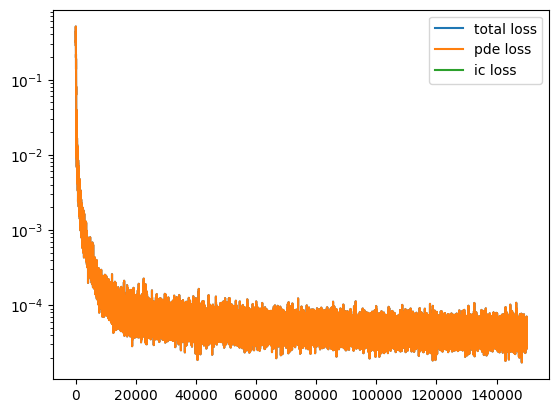

In [41]:
plt.plot(losses, label='total loss')
plt.plot(pde_losses, label='pde loss')
plt.plot(ic_losses, label='ic loss')
plt.legend()
# plt.xscale('log')
plt.yscale('log')

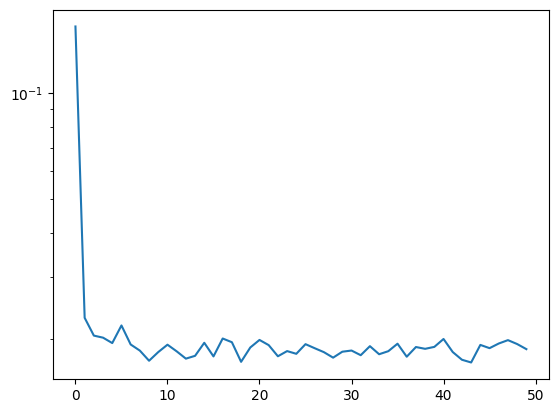

In [42]:
plt.plot(maes)
# plt.xscale('log')
plt.yscale('log')

In [43]:
print(tf.random.normal((1,)))

tf.Tensor([0.74647593], shape=(1,), dtype=float32)


In [44]:
test_pde_pts = tf.convert_to_tensor(np.load('7500pde_test_sphere.npy'), dtype=tf.float32)
test_ic_pts = tf.zeros((N_inputs, 5))
test_u_sensor_pts = tf.convert_to_tensor(np.load('7500_256_u0_test_sphere_4mode.npy'), dtype=tf.float32)
test_coefficients = tf.convert_to_tensor(np.load('7500coefficients_test_sphere_4mode.npy'), dtype=tf.float32)

In [45]:
n_eval_pts = 1000

test_coeffs = tf.random.normal((n_eval_pts, init_modes))

mean_mae = tf.constant([0.0], dtype=tf.float32)
mean_l2 = tf.constant([0.0], dtype=tf.float32)

for i in range(n_eval_pts):
    ti = test_coeffs[i:i+1:,]
    X_sens = sensor_points[:, :, 0]
    Y_sens = sensor_points[:, :, 1]
    Z_sens = sensor_points[:, :, 2]

    test_u_sensor = tf.tile(u0(X_sens, Y_sens, Z_sens, ti), multiples=[N_inputs, 1])

    x, y, z, t = tf.split(test_pde_pts, 4, axis=1)
    x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
    u_pred = tf.squeeze(hardConstraint(model, x, y, z, t, test_u_sensor, ti))
    u_true = tf.squeeze(u_analytic(x, y, z, t, ti))
    mae = tf.reduce_mean(tf.abs(u_pred - u_true))
    l2 = L2Error(u_true, u_pred)
    mean_mae += mae
    mean_l2 += l2

print(f"Average MAE over {n_eval_pts} initial conditions: {float(mean_mae / n_eval_pts): .4f}")
print(f"Average L2 over {n_eval_pts} initial conditions: {float(mean_l2 / n_eval_pts): .4f}")

Average MAE over 1000 initial conditions:  0.0238
Average L2 over 1000 initial conditions:  0.0345


In [46]:
def set_axes_equal_tensorflow(ax, x, y, z):
    x = tf.reshape(x, [-1]).numpy()
    y = tf.reshape(y, [-1]).numpy()
    z = tf.reshape(z, [-1]).numpy()

    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    z_min, z_max = z.min(), z.max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    z_range = z_max - z_min

    max_range = max(x_range, y_range, z_range)

    x_middle = 0.5 * (x_max + x_min)
    y_middle = 0.5 * (y_max + y_min)
    z_middle = 0.5 * (z_max + z_min)

    ax.set_xlim([x_middle - max_range/2, x_middle + max_range/2])
    ax.set_ylim([y_middle - max_range/2, y_middle + max_range/2])
    ax.set_zlim([z_middle - max_range/2, z_middle + max_range/2])


In [47]:
def modelResults(model, true, surface, umin=0.0, umax=1.0, vmin=0.0, vmax=1.0, t_steps=3, tmax=tmax, resolution=100, load=False, saveplots=False):
  if load:
    model.load_weights(load)

  X_sens = sensor_points[:, :, 0]
  Y_sens = sensor_points[:, :, 1]
  Z_sens = sensor_points[:, :, 2]

  test_pde_pts, test_ic_pts, test_u_sensor_pts, test_coefficients = generatePoints(20000, sphere, sensor_points, umin=0.0, umax=np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0, tmax=tmax)

  test_coeffs = tf.random.normal((1, init_modes))

  u_sens_pts = tf.tile(u0(X_sens, Y_sens, Z_sens, test_coeffs), multiples=[20000, 1])

  x, y, z = test_pde_pts[:,0], test_pde_pts[:,1], test_pde_pts[:,2]

  norm_actual, norm_pred, colors_actual, colors_pred = None, None, None, None

  for i in range(t_steps+1):
    t = tf.ones_like(x) * (i * tmax / t_steps)
    pde_pts = tf.stack([x, y, z, t], axis=1)

    u_actual = tf.reshape(u_analytic(x, y, z, t, test_coeffs), x.shape).numpy()
    u_pred = tf.reshape(hardConstraint(model, x, y, z, t, u_sens_pts, test_coeffs), x.shape).numpy()

    u_abs = np.abs(u_actual - u_pred)

    print(f"MAE error at t={i * tmax / t_steps}: {tf.reduce_mean(u_abs): .4f}")

    norm = plt.Normalize(vmin=u_abs.min(), vmax=u_abs.max())
    if i == 0:
      norm_actual = plt.Normalize(vmin=u_actual.min(), vmax=u_actual.max())
      norm_pred = plt.Normalize(vmin=u_pred.min(), vmax=u_pred.max())

    colors = plt.cm.rainbow(norm(u_abs))
    colors_actual = plt.cm.magma(norm_actual(u_actual))
    colors_pred = plt.cm.magma(norm_pred(u_pred))

    X = x.numpy().ravel()
    Y = y.numpy().ravel()
    Z = z.numpy().ravel()


    UA = u_actual.ravel()     
    UP = u_pred.ravel()       
    UABS = u_abs.ravel()      

    fig = plt.figure(figsize=(16, 6))
    ax_abs = fig.add_subplot(131, projection='3d')
    ax1    = fig.add_subplot(132, projection='3d')
    ax2    = fig.add_subplot(133, projection='3d')

    for ax in (ax_abs, ax1, ax2):
        ax.set_box_aspect([1,1,1])

    sc_abs = ax_abs.scatter(
        X, Y, Z,
        c=UABS,
        cmap='rainbow',
        norm=norm,
        marker='o'
    )

    sc_act = ax1.scatter(
        X, Y, Z,
        c=UA,
        cmap='magma',
        norm=norm_actual,
        marker='o'
    )
    sc_pred = ax2.scatter(
        X, Y, Z,
        c=UP,
        cmap='magma',
        norm=norm_pred,
        marker='o'
    )

    fig.colorbar(sc_abs,  ax=ax_abs, shrink=0.6)
    fig.colorbar(sc_act,  ax=ax1,  shrink=0.6)
    fig.colorbar(sc_pred, ax=ax2,  shrink=0.6)

    set_axes_equal_tensorflow(ax_abs,  x, y, z)
    set_axes_equal_tensorflow(ax1,    x, y, z)
    set_axes_equal_tensorflow(ax2,    x, y, z)

    plt.show()
    ax1.view_init(elev=80)
    ax2.view_init(elev=80)


  if saveplots:
    plt.savefig(f'{surface.__name__}_results.png')
  plt.show()

MAE error at t=0.0:  0.0000


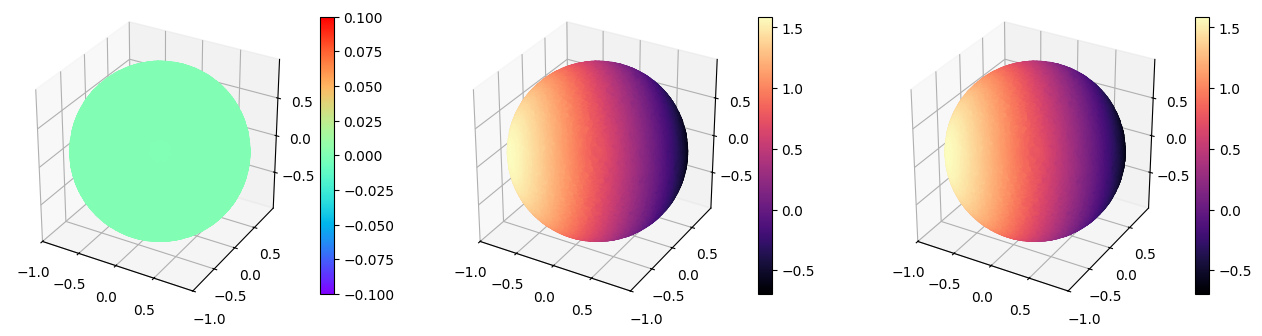

MAE error at t=0.2:  0.0019


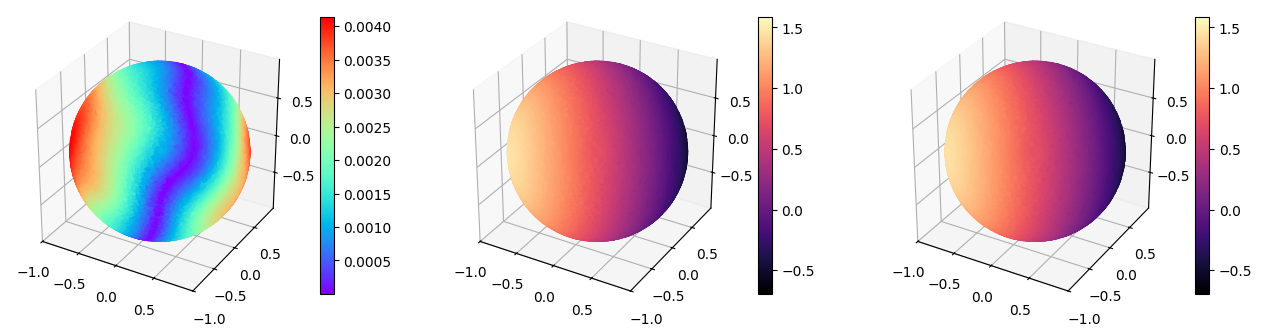

MAE error at t=0.4:  0.0080


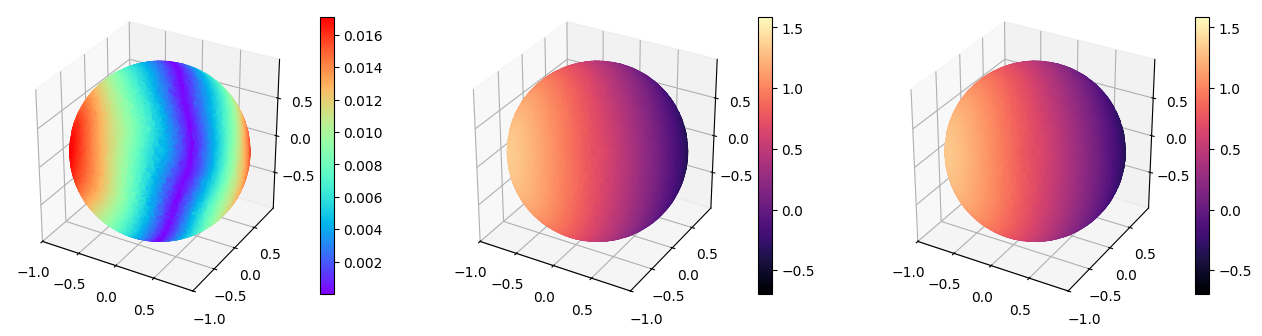

MAE error at t=0.6:  0.0173


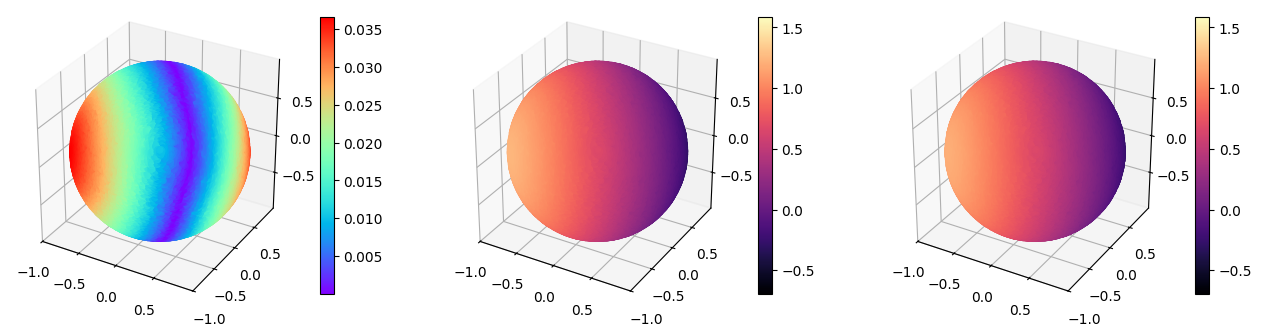

MAE error at t=0.8:  0.0288


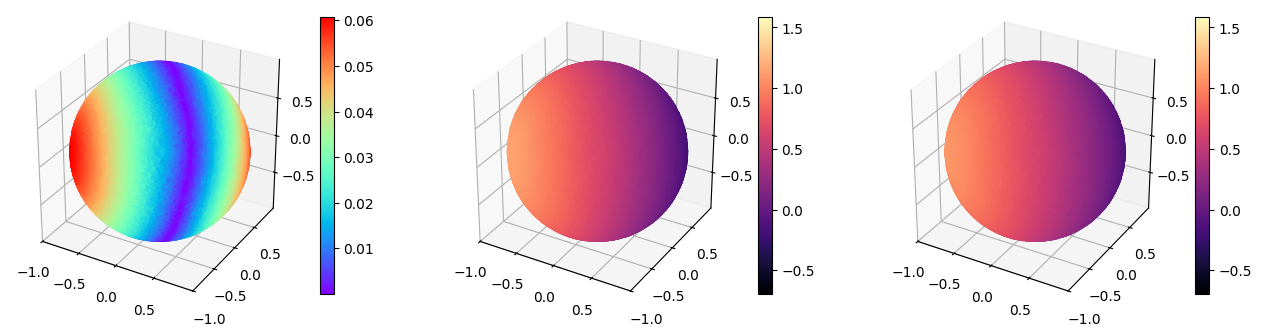

MAE error at t=1.0:  0.0416


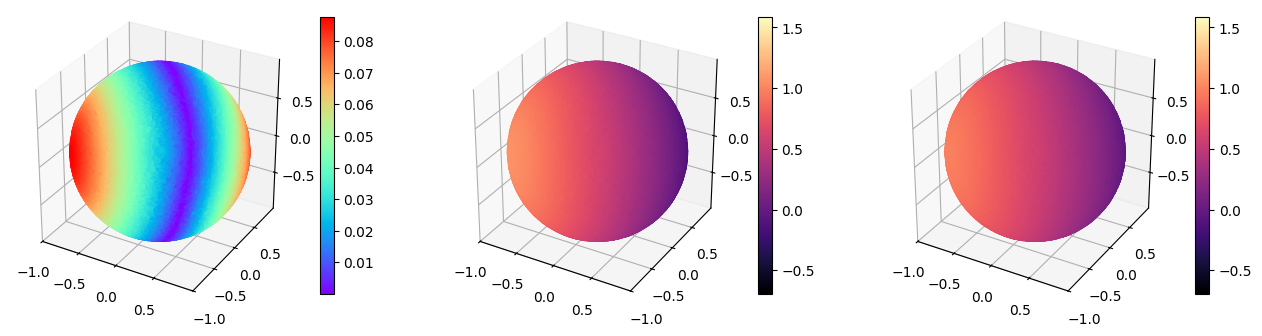

: 

In [ ]:
modelResults(model, u_analytic, sphere, umin=0.0, umax=np.pi, vmin=0.0, vmax=2*np.pi, t_steps=5, tmax=tmax, resolution=48, load=False, saveplots=False)